# Parkinson Speech Dataset with Multiple Types of Sound Recordings

##### L'objet du devoir est de mettre en pratique les différentes compétences, nécessaires au métier de data-scientist, vues en cours cette année.


## Packages

In [1]:
import selenium
from selenium import webdriver
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV

## Push sur Git 

In [10]:
!git add Projet_Python_DataAnalysis.ipynb
!git commit -m "Random Forest"
!git push 


[master cc269b7] Parameter Tuning - SVM
 1 file changed, 32 insertions(+), 23 deletions(-)
Counting objects: 3, done.
Delta compression using up to 4 threads.
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 898 bytes | 898.00 KiB/s, done.
Total 3 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/cjacques4/Parkinson-Speech-Dataset-with-Multiple-Types-of-Sound-Recordings.git
   9f941db..cc269b7  master -> master


# 1. Téléchargement de la base de données via WebScrapping

In [ ]:
driver = webdriver.Chrome(executable_path="./chromedriver")

url = "https://archive.ics.uci.edu/ml/datasets/Parkinson+Speech+Dataset+with++Multiple+Types+of+Sound+Recordings#"
driver.get(url)

In [ ]:
# Télécharger le dataset
driver.find_element_by_link_text('Data Folder').click()
xpath = '/html/body/table/tbody/tr[4]/td[2]/a'
driver.find_element_by_xpath(xpath).click()

# 2. Data Visualisation (matplotlib)

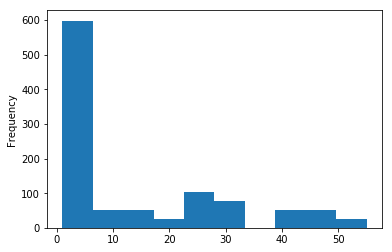

In [41]:
df.UPDRS.plot.hist()

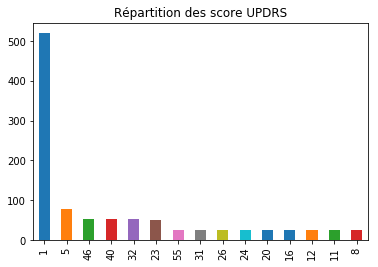

In [40]:
title = "Répartition des score UPDRS"
to_plot = df.UPDRS.value_counts(dropna=False)
to_plot.plot.bar(title=title)

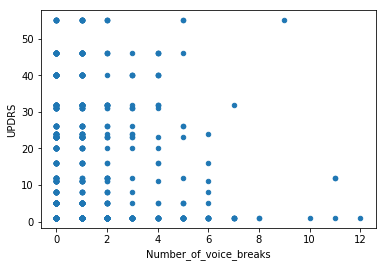

In [38]:
df.plot.scatter("Number_of_voice_breaks", "UPDRS")

# 3. Data Préparation (pandas)

## Importer la base de données

Les fichiers téléchargés étaient en .txt, nous avons alors utilisé la fonction read_csv afin de pouvoir les traiter comme des fichiers csv,et nous avons ajouter un header avec le nom de chaque colonnes : 

In [123]:
# Nous allons utilisé df comme base d'apprentissage 
# et nous utiliserons df_val comme jeu de validation final 

df = pd.read_csv ('train_data.txt', delimiter=",", header=0, index_col = [0], 
                        names=['id',
                               'Jitter_local','Jitter_local_absolute','Jitter_rap','Jitter_ppq5','Jitter_ddp',
                               'Shimmer_local','Shimmer_local_dB','Shimmer_apq3','Shimmer_apq5', 'Shimmer_apq11','Shimmer_dda', 
                               'AC','NTH','HTN', 
                               'Median_pitch','Mean_pitch','Standard_deviation','Minimum_pitch','Maximum_pitch',
                               'Number_of_pulses','Number_of_periods','Mean_period','Standard_deviation_of_period',
                               'Fraction_of_locally_unvoiced_frames','Number_of_voice_breaks','Degree_of_voice_breaks',
                               'UPDRS', 
                               'class_information']) 
  


df_val = pd.read_csv ('test_data.txt', delimiter=",", header=0, index_col = [0], 
                        names=['id',
                               'Jitter_local','Jitter_local_absolute','Jitter_rap','Jitter_ppq5','Jitter_ddp',
                               'Shimmer_local','Shimmer_local_dB','Shimmer_apq3','Shimmer_apq5', 'Shimmer_apq11','Shimmer_dda', 
                               'AC','NTH','HTN', 
                               'Median_pitch','Mean_pitch','Standard_deviation','Minimum_pitch','Maximum_pitch',
                               'Number_of_pulses','Number_of_periods','Mean_period','Standard_deviation_of_period',
                               'Fraction_of_locally_unvoiced_frames','Number_of_voice_breaks','Degree_of_voice_breaks', 
                               'class_information']) 





##  Pré-traitement

In [40]:
df.head().T

id,1,1,1,1,1
Jitter_local,0.728000,1.220000,2.502000,3.509000,2.470000
Jitter_local_absolute,0.000038,0.000074,0.000123,0.000167,0.000126
Jitter_rap,0.353000,0.732000,1.156000,1.715000,1.358000
Jitter_ppq5,0.376000,0.670000,1.634000,1.539000,1.341000
Jitter_ddp,1.059000,2.196000,3.469000,5.145000,4.075000
Shimmer_local,5.864000,8.719000,13.513000,9.112000,10.696000
Shimmer_local_dB,0.642000,0.875000,1.273000,1.040000,1.256000
Shimmer_apq3,2.058000,4.347000,5.263000,3.102000,5.262000
Shimmer_apq5,3.180000,5.166000,8.771000,4.927000,7.076000
Shimmer_apq11,7.194000,7.548000,16.779000,12.823000,9.199000


In [8]:
df_val.head()

,Jitter_local,Jitter_local_absolute,Jitter_rap,Jitter_ppq5,Jitter_ddp,Shimmer_local,Shimmer_local_dB,Shimmer_apq3,Shimmer_apq5,Shimmer_apq11,...,Minimum_pitch,Maximum_pitch,Number_of_pulses,Number_of_periods,Mean_period,Standard_deviation_of_period,Fraction_of_locally_unvoiced_frames,Number_of_voice_breaks,Degree_of_voice_breaks,class_information
id,,,,,,,,,,,,,,,,,,,,,
1,0.143,0.000007,0.073,0.081,0.219,1.236,0.107,0.612,0.904,0.894,...,198.665,202.214,194.0,193.0,0.004988,0.000020,0.0,0.0,0.0,1
1,0.162,0.000008,0.087,0.089,0.260,1.338,0.117,0.630,0.948,1.017,...,197.220,206.060,198.0,197.0,0.004940,0.000046,0.0,0.0,0.0,1
1,0.140,0.000007,0.075,0.089,0.224,1.086,0.094,0.556,0.747,0.823,...,202.324,206.182,200.0,199.0,0.004900,0.000023,0.0,0.0,0.0,1
1,0.150,0.000007,0.080,0.097,0.240,1.049,0.091,0.533,0.698,0.777,...,205.407,209.927,204.0,203.0,0.004820,0.000022,0.0,0.0,0.0,1
1,0.208,0.000009,0.077,0.095,0.230,1.241,0.109,0.487,0.715,1.568,...,218.455,243.523,221.0,220.0,0.004416,0.000120,0.0,0.0,0.0,1


In [9]:
df.shape

(1039, 28)

In [10]:
df_val.shape

(167, 27)

In [11]:
df.dtypes

Jitter_local                           float64
Jitter_local_absolute                  float64
Jitter_rap                             float64
Jitter_ppq5                            float64
Jitter_ddp                             float64
Shimmer_local                          float64
Shimmer_local_dB                       float64
Shimmer_apq3                           float64
Shimmer_apq5                           float64
Shimmer_apq11                          float64
Shimmer_dda                            float64
AC                                     float64
NTH                                    float64
HTN                                    float64
Median_pitch                           float64
Mean_pitch                             float64
Standard_deviation                     float64
Minimum_pitch                          float64
Maximum_pitch                          float64
Number_of_pulses                         int64
Number_of_periods                        int64
Mean_period  

In [12]:
#Check NA train
null_counts = df.isnull().sum()
print("Number of null values in each column:\n{}".format(null_counts))

Number of null values in each column:
Jitter_local                           0
Jitter_local_absolute                  0
Jitter_rap                             0
Jitter_ppq5                            0
Jitter_ddp                             0
Shimmer_local                          0
Shimmer_local_dB                       0
Shimmer_apq3                           0
Shimmer_apq5                           0
Shimmer_apq11                          0
Shimmer_dda                            0
AC                                     0
NTH                                    0
HTN                                    0
Median_pitch                           0
Mean_pitch                             0
Standard_deviation                     0
Minimum_pitch                          0
Maximum_pitch                          0
Number_of_pulses                       0
Number_of_periods                      0
Mean_period                            0
Standard_deviation_of_period           0
Fraction_of_locally

### Visualisation des NA

Ici nous avons de la chance car notre base de données est très propre, elle ne contient aucune valeur nulle. 

In [13]:
#Check NA test
null_counts = df_val.isnull().sum()
print("Number of null values in each column:\n{}".format(null_counts))

Number of null values in each column:
Jitter_local                           0
Jitter_local_absolute                  0
Jitter_rap                             0
Jitter_ppq5                            0
Jitter_ddp                             0
Shimmer_local                          0
Shimmer_local_dB                       0
Shimmer_apq3                           0
Shimmer_apq5                           0
Shimmer_apq11                          0
Shimmer_dda                            0
AC                                     0
NTH                                    0
HTN                                    0
Median_pitch                           0
Mean_pitch                             0
Standard_deviation                     0
Minimum_pitch                          0
Maximum_pitch                          0
Number_of_pulses                       0
Number_of_periods                      0
Mean_period                            0
Standard_deviation_of_period           0
Fraction_of_locally

In [42]:
#test = df_val.head()
#test.iloc[0][0]

# 4. Modélisation (scikit learn)

In [124]:
#Read data 
target = df.UPDRS
df.drop(['UPDRS'], axis='columns', inplace=True)
X = df


## Séparer le jeu de données en train et test avec une cross validation

In [150]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.33)

### Standardiser les valeurs

In [151]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)                 
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

## Choix d'un algorithme d'apprentissage

### Support Vector Machine (SVM)

Dans un premier temps, nous allons lancer un svm avec les paramètres par défaut puis nous allons aller au-delà de ces paramètres à l’aide d’un Grid Search :

In [152]:
from sklearn import svm
algorithme = svm.SVC()
algorithme.get_params()

{'C': 1.0,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'auto',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [153]:
from sklearn import cross_validation
cross_validation.cross_val_score(algorithme, X, target, n_jobs=-1)

array([0.49431818, 0.49712644, 0.51032448])

### Aller au delà des paramètres par défaut :

In [154]:
from sklearn import grid_search
parameters = {  'gamma' : [0.1,0.01, 0.001, 0.0001],
                'C'      : [100,1000, 10000],
                "probability" : [True],
                'kernel' : ['rbf', 'poly', 'sigmoid','linear'],
                "degree" : [1,3,5]}

grid       = grid_search.GridSearchCV(algorithme, parameters, n_jobs=-1)

grid.fit(X_train, y_train)

print (grid.best_score_, grid.best_estimator_)



0.75 SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=1, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [155]:
y_pred=grid.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7580174927113703


### Random Forest

In [156]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

algorithme2 = RandomForestClassifier(n_estimators=100) 
algorithme.get_params()

#Train the model using the training sets y_pred=clf.predict(X_test)
algorithme2.fit(X_train,y_train)

y_pred=algorithme2.predict(X_test)


In [157]:
from sklearn import metrics

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.7842565597667639


# Tester tous les algos

In [67]:
def get_sklearn_algorithms(verbose = False):
    """
    Explore all submodule of sklearn and fetch functions having a 'fit' attribute.
    
    Be careful : some functions are not models (ex : crossvalidators)
    Parameters :
        debug = print or not stuff on console
    Return :
        dict : { module : [ fit_functions] }
    """
    from collections import defaultdict
    import importlib
    import sklearn
    algos = defaultdict(list)
    if verbose : print (dir(sklearn))
    for nom_module in sklearn.__dict__['__all__']:    
        if verbose : print (nom_module)
        try:
            to_import = "sklearn.%s"%nom_module
            module    = importlib.import_module(to_import)
            for nom_fonction in dir(module):
                fonction = getattr(module, nom_fonction)
                if hasattr(fonction, "fit"):
                    if verbose : print (" nom algorithme  = ", nom_fonction)
                    algos[nom_module].append(fonction)                                            
        except Exception as e:
            if verbose : print (e)
        if verbose: print ("="*30)
    return algos

In [68]:
algos = get_sklearn_algorithms(True)
for key in algos.keys():
    print ("\n===>",key)
    algos_ = []
    for algo in algos[key]:
        classe_algo = str(algo)
        nom_algo    = classe_algo[str(classe_algo).rfind(".")+1:str(classe_algo).rfind("'")]
        algos_.append(nom_algo)
    print (",".join(algos_))

['_ASSUME_FINITE', '__SKLEARN_SETUP__', '__all__', '__builtins__', '__cached__', '__check_build', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', '_contextmanager', 'base', 'clone', 'config_context', 'cross_validation', 'datasets', 'ensemble', 'exceptions', 'externals', 'feature_extraction', 'feature_selection', 'gaussian_process', 'get_config', 'grid_search', 'linear_model', 'logger', 'logging', 'metrics', 'model_selection', 'multiclass', 'neighbors', 'os', 'preprocessing', 'random_projection', 're', 'set_config', 'setup_module', 'svm', 'sys', 'tree', 'utils', 'warnings']
calibration
 nom algorithme  =  CalibratedClassifierCV
 nom algorithme  =  IsotonicRegression
 nom algorithme  =  LabelBinarizer
 nom algorithme  =  LabelEncoder
 nom algorithme  =  LinearSVC
 nom algorithme  =  _CalibratedClassifier
 nom algorithme  =  _SigmoidCalibration
cluster
 nom algorithme  =  AffinityPropagation
 nom algorithme  =  AgglomerativeClustering

/anaconda3/lib/python3.7/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [69]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [70]:
performances               = {}
modeles_a_tester           = []
classes_de_models_a_tester = algos.keys()
best_algorithm = 0
best_perf = 0
for classe_de_models in classes_de_models_a_tester:
    modeles_a_tester.extend(algos[classe_de_models])
    
for pointeur_vers_algo in modeles_a_tester:
    try:
        algorithme = pointeur_vers_algo()
        doc        = algorithme.__doc__
        name       = doc[:min(doc.find(":"), 25)].strip()
        print (name)
        algorithme.fit(X_train, y_train)
        performance = algorithme.score(X_test, y_test)
        print (performance)
        if performance >  best_perf:
            best_algorithm = algorithme
            best_perf = performance
            
        if 0<performance and performance<1:
            performances[name] = [performance]
    except Exception as e:
        if "label" in str(e): print ("Algo de classification")
        else                : print (str(e)[:50])
    print("="*30)

Probability calibration w
0.6822157434402333
Isotonic regression model
X should be a 1d array
Binarize labels in a one-
fit() takes 2 positional arguments but 3 were give
Encode labels with value
fit() takes 2 positional arguments but 3 were give
Linear Support Vector Cla
0.6793002915451894
__init__() missing 1 required positional argument:
Sigmoid regression model.
bad input shape (696, 27)
Perform Affinity Propagat
'AffinityPropagation' object has no attribute 'sco
Agglomerative Cluste
'AgglomerativeClustering' object has no attribute 
Implements the Birch clus
'Birch' object has no attribute 'score'
Perform DBSCAN clustering
'DBSCAN' object has no attribute 'score'
Agglomerate features.
'FeatureAgglomeration' object has no attribute 'sc
K-Means clustering

    R


/anaconda3/lib/python3.7/site-packages/sklearn/cluster/birch.py:77: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  node1_dist, node2_dist = dist[[farthest_idx]]


-4244.588820717321
Mean shift clustering usi
'MeanShift' object has no attribute 'score'
Mini-Batch K-Means cluste
-4830.744915080933
Spectral biclustering (Kl
'SpectralBiclustering' object has no attribute 'sc
Apply clustering to a pro
'SpectralClustering' object has no attribute 'scor
Spectral Co-Clustering al
'SpectralCoclustering' object has no attribute 'sc
An object for detecting o


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


0.4839650145772595
Maximum likelihood covari
-0.9574269537812299
Sparse inverse covariance


/anaconda3/lib/python3.7/site-packages/sklearn/covariance/graph_lasso_.py:252: ConvergenceWarning: graph_lasso: did not converge after 100 iteration: dual gap: 1.350e-01
  ConvergenceWarning)


-14.772341697292916
Sparse inverse covariance
-25.171330632155815
LedoitWolf Estimator
-16.230523700310876
Minimum Covariance Determ
-242.1590779684244
Oracle Approximating Shri
-14.55774624045321
Covariance estimator with
-20.505545494131546
CCA Canonical Correlation
-0.0023931700923183197
PLSCanonical implements
-0.20257938475580528
PLS regression

    PLSRe
0.481067247462303
Partial Least Square SVD
'PLSSVD' object has no attribute 'score'
Dictionary learning


/anaconda3/lib/python3.7/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)


KeyboardInterrupt: 

In [159]:
best_algorithm

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [160]:
performances

{'Probability calibration w': [0.5276967930029155],
 'Linear Support Vector Cla': [0.5568513119533528],
 'An object for detecting o': [0.4489795918367347],
 'DummyClassifier is a': [0.2536443148688047],
 'An AdaBoost classifier.': [0.5306122448979592],
 'A Bagging classifier.': [0.5597667638483965],
 'A Bagging regressor.': [0.00262783125249344],
 'An extra-trees classifier': [0.5626822157434402],
 'An extra-trees regressor.': [0.022699082602627763],
 'Gradient Boosting for cla': [0.5801749271137027],
 'Gradient Boosting for reg': [0.03715869323315757],
 'A random forest classifie': [0.5830903790087464],
 'A random forest regressor': [0.07060703548922509],
 'Gaussian process classifi': [0.5335276967930029],
 'Bayesian ARD regression.': [0.014504604551369482],
 'Bayesian ridge regression': [0.0235417010498713],
 'Linear regression with co': [0.026939262043189638],
 'Elastic Net model with it': [0.023287470066553073],
 'Linear regression model t': [0.023520210592334334],
 'Linear Model t

In [161]:
import pandas as pd
df_performances = pd.DataFrame(performances).T

col_name = "performance"
df_performances.columns = [col_name]

df_performances = df_performances.sort_values(col_name)

In [162]:
df_performances

,performance
Ordinary least squar,0.002200
A Bagging regressor.,0.002628
Linear least squares with,0.005439
Ridge regression with bui,0.011540
Bayesian ARD regression.,0.014505
Lasso model fit with Lars,0.019299
Lasso linear model with i,0.022200
An extra-trees regressor.,0.022699
Elastic Net model with it,0.023287
"Cross-validated Lasso, us",0.023508


In [163]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

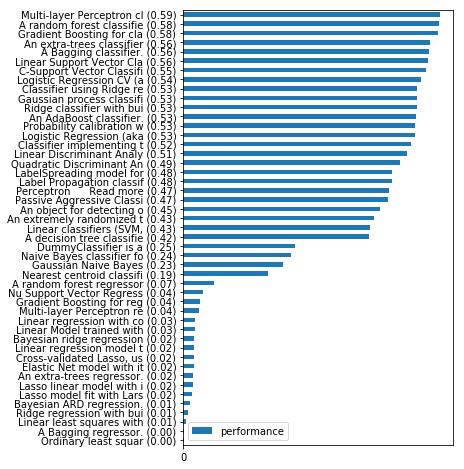

In [164]:
new_labels = []
for i, index in enumerate(df_performances.index):
    new_label = "%s (%.2f)"%(index,df_performances.performance[i])
    new_labels.append(new_label.replace("\n", " "))
    
fig , axes = plt.subplots(1,1)
df_performances.index = new_labels
fig.set_size_inches(15,8)
fig.subplots_adjust(left=0.65)
df_performances.sort_values(col_name).plot(kind='barh', ax=axes)
axes.xaxis.set_major_locator(ticker.MultipleLocator(1))

pass